In [10]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import metrics

import sys

import models.cnn as cnn
import models.resnet as resnet
import data_visualisation as dv
import data_augmentation as da

# Load Data

In [4]:
# load data
thismodule = sys.modules[__name__]

with np.load('data/PTB_XL_HB_1s_window.npz', allow_pickle=True) as data:
    for k in data.keys():
        if 'text' in k:
            setattr(thismodule, k, data[k])
        else:
            setattr(thismodule, k, data[k].astype(float))

In [11]:
def augment_ecg_signal(signal):
    drifted_signal, _ = da.add_random_baseline_drift(signal, strength_range=(1.5,2.5), drift_wavelength_range=(300,500))
    noised_drifted_signal = da.add_random_noise(drifted_signal, (0, 0.2))
    return noised_drifted_signal

def augment_ecg_signal_batch(signals, labels, batch_size):
    while True:
        
        indices = np.random.randint(0, signals.shape[0], size=batch_size)
        batch = signals[indices]
        batch_labels = labels[indices]
        
        augmented_batch = np.array([augment_ecg_signal(sample) for sample in batch])
        
        yield (augmented_batch, batch_labels)

# CNN Model

In [20]:
num_classes = 5
print(X_train.shape)
print(X_train.shape[1:])
X_input = keras.Input(shape=X_train.shape[1:])
outputs, feature_output = cnn.model(X_input, num_classes=num_classes, filters=[16, 32, 64, 64, 32], kernels=[5,5,7,3,3], hidden_units=[128, 64], dropout=[0.5, 0.5])

model = keras.Model(inputs=X_input, outputs=outputs)
optim = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall', metrics.binary_accuracy])
model.summary()

(229753, 100, 12)
(100, 12)
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 100, 12)]         0         
                                                                 
 conv1 (Conv1D)              (None, 96, 16)            976       
                                                                 
 bn1 (BatchNormalization)    (None, 96, 16)            64        
                                                                 
 activation_21 (Activation)  (None, 96, 16)            0         
                                                                 
 max_pooling1d_16 (MaxPoolin  (None, 48, 16)           0         
 g1D)                                                            
                                                                 
 conv2 (Conv1D)              (None, 44, 32)            2592      
                               

Epoch 1/10
3589/3589 [==============================] - 37s 10ms/step - loss: 0.3374 - accuracy: 0.6696 - precision: 0.7667 - recall: 0.6176 - binary_accuracy: 0.8569 - val_loss: 0.3171 - val_accuracy: 0.6955 - val_precision: 0.7702 - val_recall: 0.6653 - val_binary_accuracy: 0.8658
Epoch 2/10
3589/3589 [==============================] - 34s 9ms/step - loss: 0.2897 - accuracy: 0.7140 - precision: 0.8064 - recall: 0.6897 - binary_accuracy: 0.8805 - val_loss: 0.3165 - val_accuracy: 0.6798 - val_precision: 0.7833 - val_recall: 0.6763 - val_binary_accuracy: 0.8714
Epoch 3/10
3589/3589 [==============================] - 34s 9ms/step - loss: 0.2736 - accuracy: 0.7290 - precision: 0.8185 - recall: 0.7122 - binary_accuracy: 0.8884 - val_loss: 0.3119 - val_accuracy: 0.6748 - val_precision: 0.7898 - val_recall: 0.6762 - val_binary_accuracy: 0.8732
Epoch 4/10
3589/3589 [==============================] - 34s 9ms/step - loss: 0.2660 - accuracy: 0.7301 - precision: 0.8230 - recall: 0.7224 - binary_a

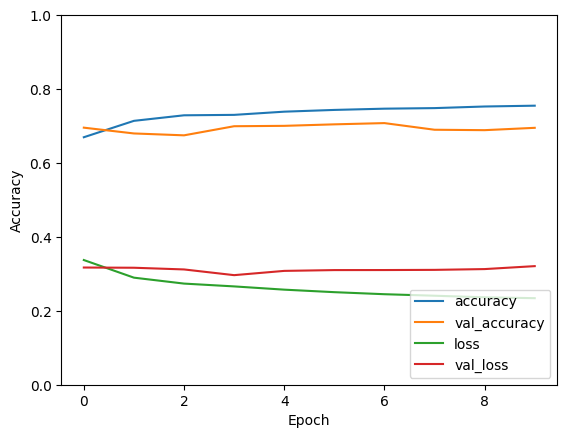

In [21]:
# train model

batch_size = 64

train_generator = augment_ecg_signal_batch(X_train, Y_train, batch_size=batch_size)

history = model.fit(train_generator, epochs=10, batch_size=batch_size, validation_data=(X_val, Y_val), steps_per_epoch=X_train.shape[0]//batch_size, verbose=1)

# plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

# ResNet

In [24]:
num_classes = 5
X_input = keras.Input(shape=X_train.shape[1:])
outputs, feature_output = resnet.model(X_input, num_classes=num_classes)

model = keras.Model(inputs=X_input, outputs=outputs)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall', metrics.binary_accuracy])
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 100, 12)]    0           []                               
                                                                                                  
 conv1 (Conv1D)                 (None, 96, 16)       976         ['input_10[0][0]']               
                                                                                                  
 bn1 (BatchNormalization)       (None, 96, 16)       64          ['conv1[0][0]']                  
                                                                                                  
 activation_35 (Activation)     (None, 96, 16)       0           ['bn1[0][0]']                    
                                                                                            

Epoch 1/10
3589/3589 [==============================] - 39s 10ms/step - loss: 0.3394 - accuracy: 0.6661 - precision: 0.7662 - recall: 0.6088 - binary_accuracy: 0.8554 - val_loss: 0.3000 - val_accuracy: 0.6743 - val_precision: 0.7823 - val_recall: 0.6894 - val_binary_accuracy: 0.8735
Epoch 2/10
3589/3589 [==============================] - 34s 10ms/step - loss: 0.2880 - accuracy: 0.7154 - precision: 0.8065 - recall: 0.6943 - binary_accuracy: 0.8815 - val_loss: 0.3014 - val_accuracy: 0.6973 - val_precision: 0.7899 - val_recall: 0.6748 - val_binary_accuracy: 0.8730
Epoch 3/10
3589/3589 [==============================] - 35s 10ms/step - loss: 0.2729 - accuracy: 0.7276 - precision: 0.8165 - recall: 0.7139 - binary_accuracy: 0.8879 - val_loss: 0.2947 - val_accuracy: 0.6999 - val_precision: 0.7929 - val_recall: 0.6775 - val_binary_accuracy: 0.8743
Epoch 4/10
3589/3589 [==============================] - 35s 10ms/step - loss: 0.2641 - accuracy: 0.7334 - precision: 0.8231 - recall: 0.7256 - binar

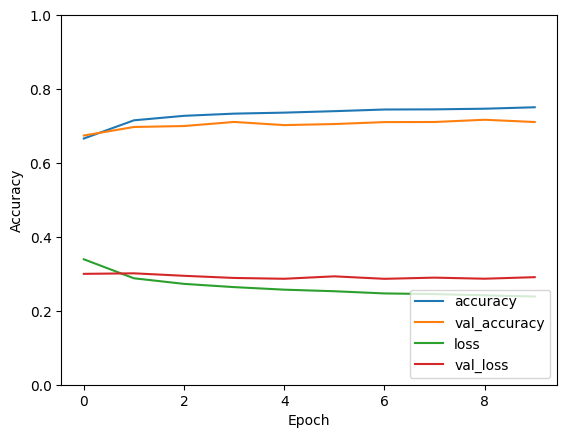

In [25]:
# train model

batch_size = 64

train_generator = augment_ecg_signal_batch(X_train, Y_train, batch_size=batch_size)

history = model.fit(train_generator, epochs=10, batch_size=batch_size, validation_data=(X_val, Y_val), steps_per_epoch=X_train.shape[0]//batch_size, verbose=1)

# plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

In [28]:
# evaluate model
test_loss, test_acc, test_prec, test_rec, test_bin_acc = model.evaluate(X_test, Y_test, verbose=2)

print('Test accuracy:', test_acc)
print('Test precision:', test_prec)
print('Test recall:', test_rec)
print('Test F1:', 2 * (test_prec * test_rec) / (test_prec + test_rec))
print('Test binary accuracy:', test_bin_acc)


923/923 - 2s - loss: 0.2885 - accuracy: 0.7216 - precision: 0.7949 - recall: 0.6897 - binary_accuracy: 0.8781 - 2s/epoch - 3ms/step
Test accuracy: 0.7215597033500671
Test precision: 0.7948565483093262
Test recall: 0.6897057294845581
Test F1: 0.738557248405817
Test binary accuracy: 0.8781286478042603


In [34]:
# resnet50

num_classes = 5
X_input = keras.Input(shape=X_train.shape[1:])
out, fe = resnet.model(X_input, num_classes=num_classes, filters = [16, 16], kernels = [5, 3], layers=10, hidden_units=128)

model3 = keras.Model(inputs=X_input, outputs=out)

model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall', metrics.binary_accuracy])
model3.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 100, 12)]    0           []                               
                                                                                                  
 conv1 (Conv1D)                 (None, 96, 16)       976         ['input_15[0][0]']               
                                                                                                  
 bn1 (BatchNormalization)       (None, 96, 16)       64          ['conv1[0][0]']                  
                                                                                                  
 activation_167 (Activation)    (None, 96, 16)       0           ['bn1[0][0]']                    
                                                                                            

Epoch 1/10
3589/3589 [==============================] - 81s 20ms/step - loss: 0.3070 - accuracy: 0.6930 - precision: 0.7918 - recall: 0.6595 - binary_accuracy: 0.8708 - val_loss: 0.3130 - val_accuracy: 0.7079 - val_precision: 0.7749 - val_recall: 0.6798 - val_binary_accuracy: 0.8697
Epoch 2/10
3589/3589 [==============================] - 73s 20ms/step - loss: 0.2611 - accuracy: 0.7319 - precision: 0.8244 - recall: 0.7273 - binary_accuracy: 0.8927 - val_loss: 0.2885 - val_accuracy: 0.7010 - val_precision: 0.7904 - val_recall: 0.7020 - val_binary_accuracy: 0.8781
Epoch 3/10
3589/3589 [==============================] - 71s 20ms/step - loss: 0.2473 - accuracy: 0.7419 - precision: 0.8316 - recall: 0.7451 - binary_accuracy: 0.8982 - val_loss: 0.2924 - val_accuracy: 0.6924 - val_precision: 0.7781 - val_recall: 0.7186 - val_binary_accuracy: 0.8776
Epoch 4/10
3589/3589 [==============================] - 73s 20ms/step - loss: 0.2347 - accuracy: 0.7506 - precision: 0.8399 - recall: 0.7617 - binar

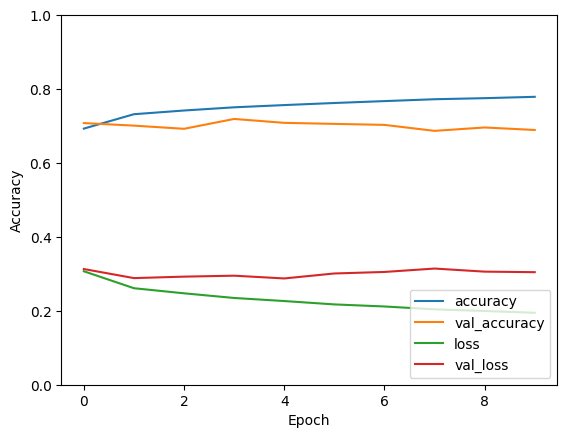

In [35]:
# train model

batch_size = 64

train_generator = augment_ecg_signal_batch(X_train, Y_train, batch_size=batch_size)

history = model3.fit(train_generator, epochs=10, batch_size=batch_size, validation_data=(X_val, Y_val), steps_per_epoch=X_train.shape[0]//batch_size, verbose=1)

# plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()